# Loading libraries

In [1]:
from typing import List, Union, Dict
import sys
import os
import yaml
import warnings
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
import optuna
import darts

from darts import models
from darts import metrics
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

from data_formatter.base import *
from bin.utils import *

# Check statistics of the data

In [2]:
# load yaml config file
with open('./config/weinstock.yaml', 'r') as f:
    config = yaml.safe_load(f)

# set interpolation params for no interpolation
new_config = config.copy()
new_config['interpolation_params']['gap_threshold'] = 5
new_config['interpolation_params']['min_drop_length'] = 0
# set split params for no splitting
new_config['split_params']['test_percent_subjects'] = 0
new_config['split_params']['length_segment'] = 0
# set scaling params for no scaling
new_config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(new_config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 0
	Extracted segments: 28577
	Interpolated values: 23438
	Percent of values interpolated: 3.65%
Splitting data...
	Train: 642376 (100.00%)
	Val: 0 (0.00%)
	Test: 0 (0.00%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


Train segment lengths:
	Min:  1
	Max:  1772
	1st Quartile:  1.0
	Median:  3.0
	Mean:  22.47877663855548
	Std:  58.723825174631486


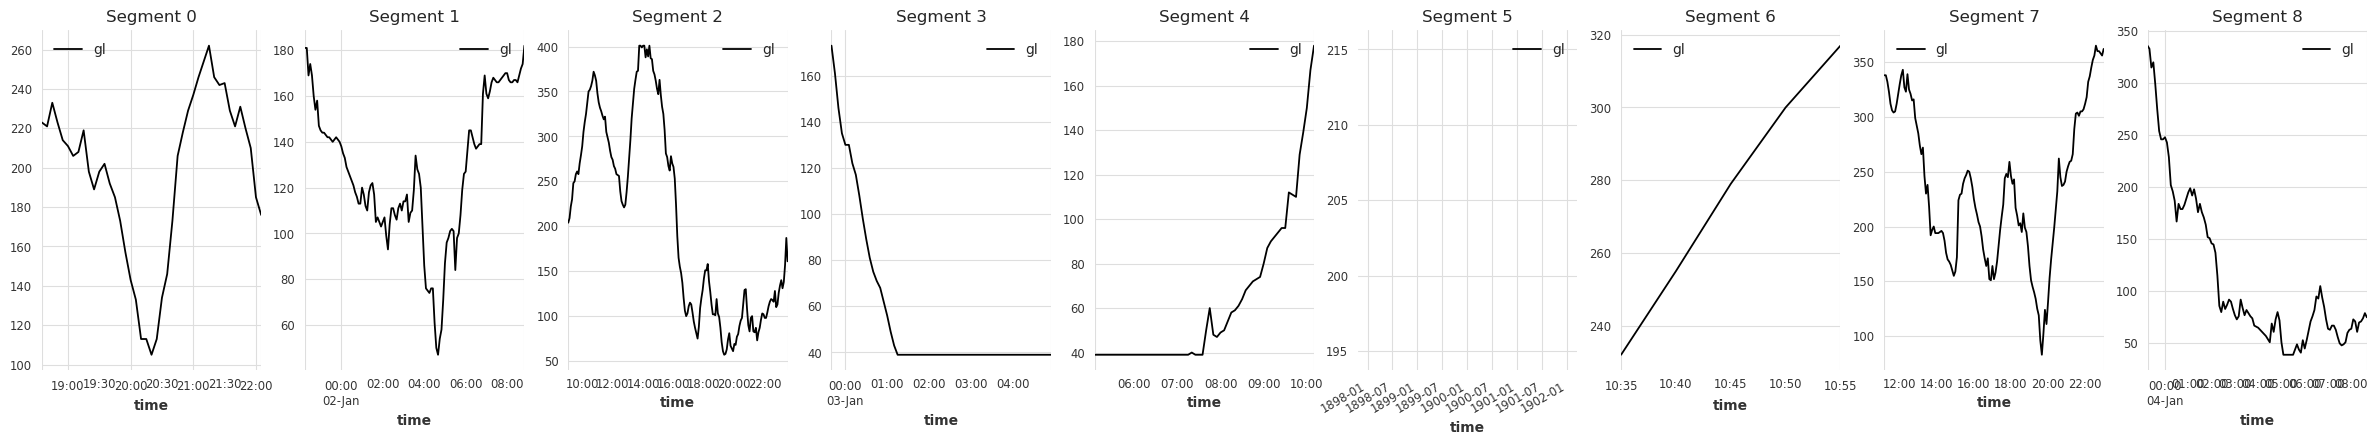

In [3]:
# print min, max, median, mean, std of segment lengths
segment_lens = []
for group, data in formatter.train_data.groupby('id_segment'):
    segment_lens.append(len(data))
print('Train segment lengths:')
print('\tMin: ', min(segment_lens))
print('\tMax: ', max(segment_lens))
print('\t1st Quartile: ', np.quantile(segment_lens, 0.25))
print('\tMedian: ', np.median(segment_lens))
print('\tMean: ', np.mean(segment_lens))
print('\tStd: ', np.std(segment_lens))

# plot first 9 segments
num_segments = 9
plot_data = formatter.train_data

fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data.plot(x='time', y='gl', ax=axs[i], title='Segment {}'.format(group))
    if i >= num_segments - 1:
        break

Segment 0 is too short
Segment 1 is too short
Segment 2 is too short
Segment 3 is too short
Segment 4 is too short
Segment 5 is too short
Segment 6 is too short
Segment 7 is too short
Segment 8 is too short
Segment 9 is too short
Segment 10 is too short
Segment 11 is too short
Segment 12 is too short
Segment 13 is too short
Segment 14 is too short
Segment 15 is too short
Segment 16 is too short
Segment 17 is too short
Segment 18 is too short
Segment 19 is too short
Segment 20 is too short
Segment 21 is too short
Segment 22 is too short
Segment 23 is too short
Segment 24 is too short
Segment 25 is too short
Segment 26 is too short
Segment 27 is too short
Segment 28 is too short
Segment 29 is too short
Segment 30 is too short
Segment 31 is too short
Segment 32 is too short
Segment 33 is too short
Segment 34 is too short
Segment 35 is too short
Segment 36 is too short
Segment 37 is too short
Segment 38 is too short
Segment 39 is too short
Segment 40 is too short
Segment 41 is too short
Se

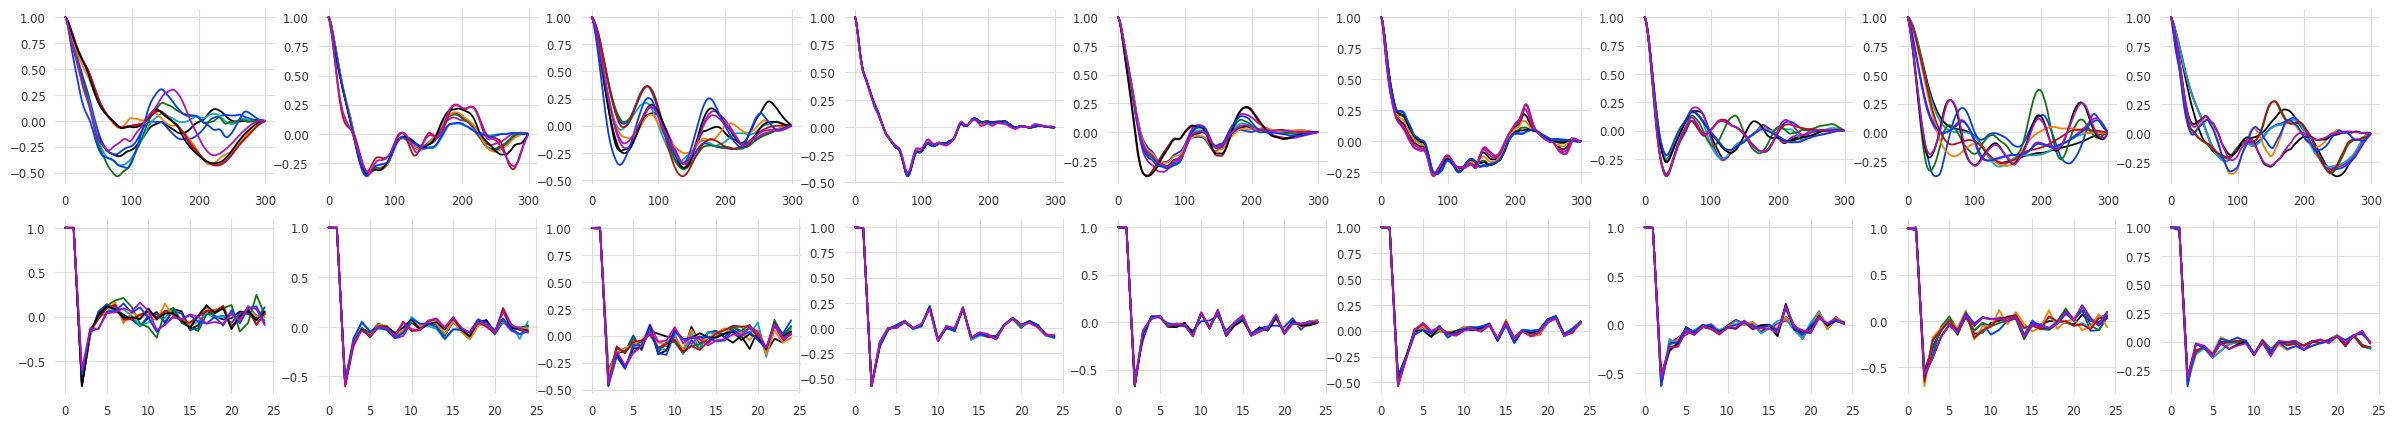

In [4]:
# plot acf of random samples from first 9 segments segments
fig, ax = plt.subplots(2, num_segments, figsize=(30, 5))
lags = 300; k = 0
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data = data['gl']
    if len(data) < lags:
        print('Segment {} is too short'.format(group))
        continue
    else:
        # select 10 random samples from index of data
        sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)
        # plot acf / pacf of each sample
        for j in sample:
            acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
            pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
            ax[0, k].plot(acf)
            ax[1, k].plot(pacf)
        k += 1
        if k >= num_segments:
            break

ACF plots suggest that significant dependency persists up to 200 points (~16 hours). The analysis of distribution of segment lengths suggests that there are too many short segments. 
Based on this, interpolation should be performed of missing values up to 45 minutes (9 points), segments less than 200 points should be dropped.

In [5]:
# set interpolation params for interpolation
new_config['interpolation_params']['gap_threshold'] = 45 # minutes - use as in config file 
new_config['interpolation_params']['min_drop_length'] = 240

formatter = DataFormatter(new_config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 1416
	Extracted segments: 681
	Interpolated values: 140564
	Percent of values interpolated: 24.24%
Splitting data...
	Train: 579782 (100.00%)
	Val: 0 (0.00%)
	Test: 0 (0.00%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


Train segment lengths:
	Min:  245
	Max:  2478
	1st Quartile:  404.0
	Median:  648.0
	3rd Quartile:  1199.0
	Mean:  851.3685756240823
	Std:  550.0751924138474


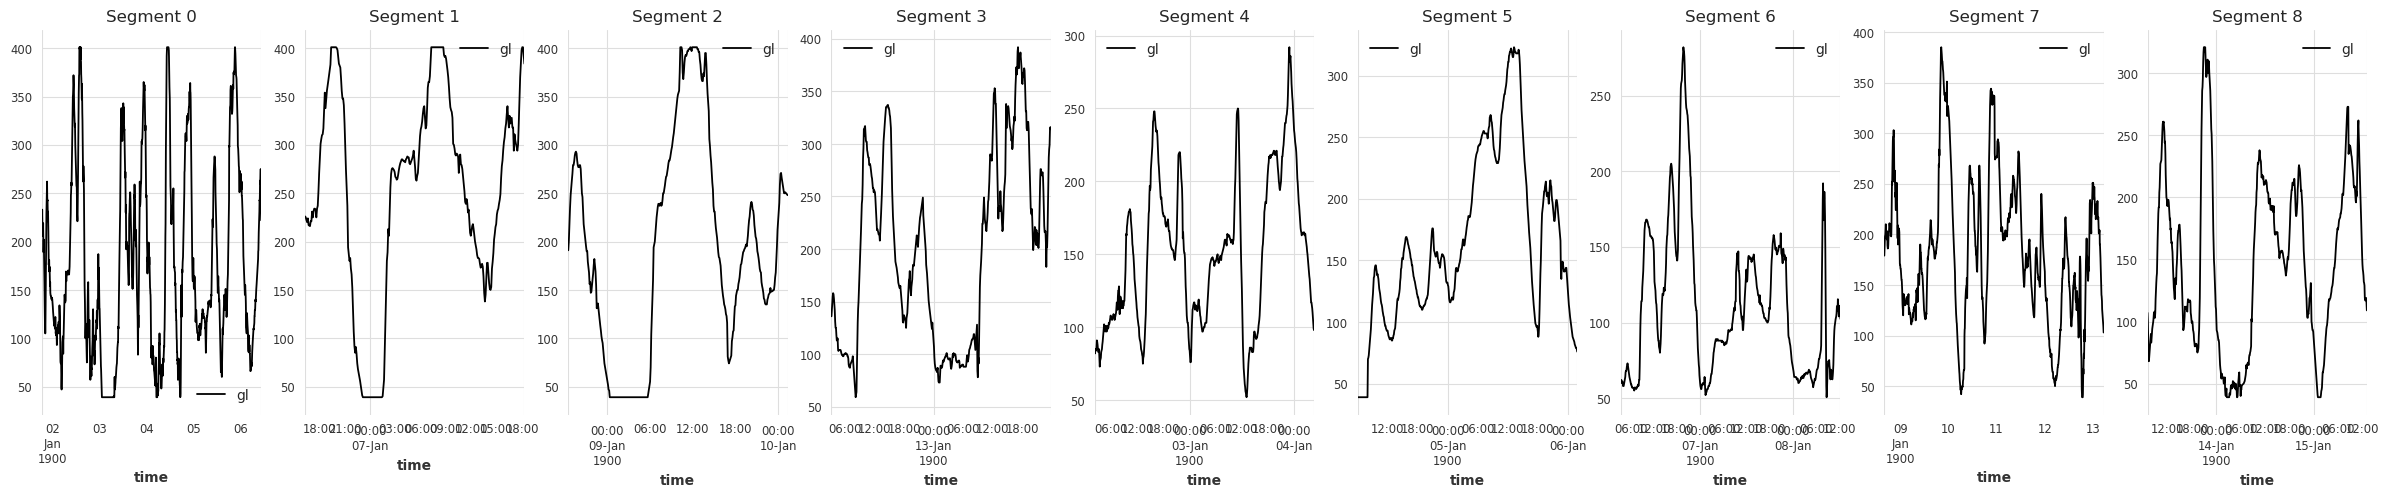

In [6]:
# print min, max, median, mean, std of segment lengths
segment_lens = []
for group, data in formatter.train_data.groupby('id_segment'):
    segment_lens.append(len(data))
print('Train segment lengths:')
print('\tMin: ', min(segment_lens))
print('\tMax: ', max(segment_lens))
print('\t1st Quartile: ', np.quantile(segment_lens, 0.25))
print('\tMedian: ', np.median(segment_lens))
print('\t3rd Quartile: ', np.quantile(segment_lens, 0.75))
print('\tMean: ', np.mean(segment_lens))
print('\tStd: ', np.std(segment_lens))

# plot first 9 segments
num_segments = 9
plot_data = formatter.train_data

fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data.plot(x='time', y='gl', ax=axs[i], title='Segment {}'.format(group))
    if i >= num_segments - 1:
        break

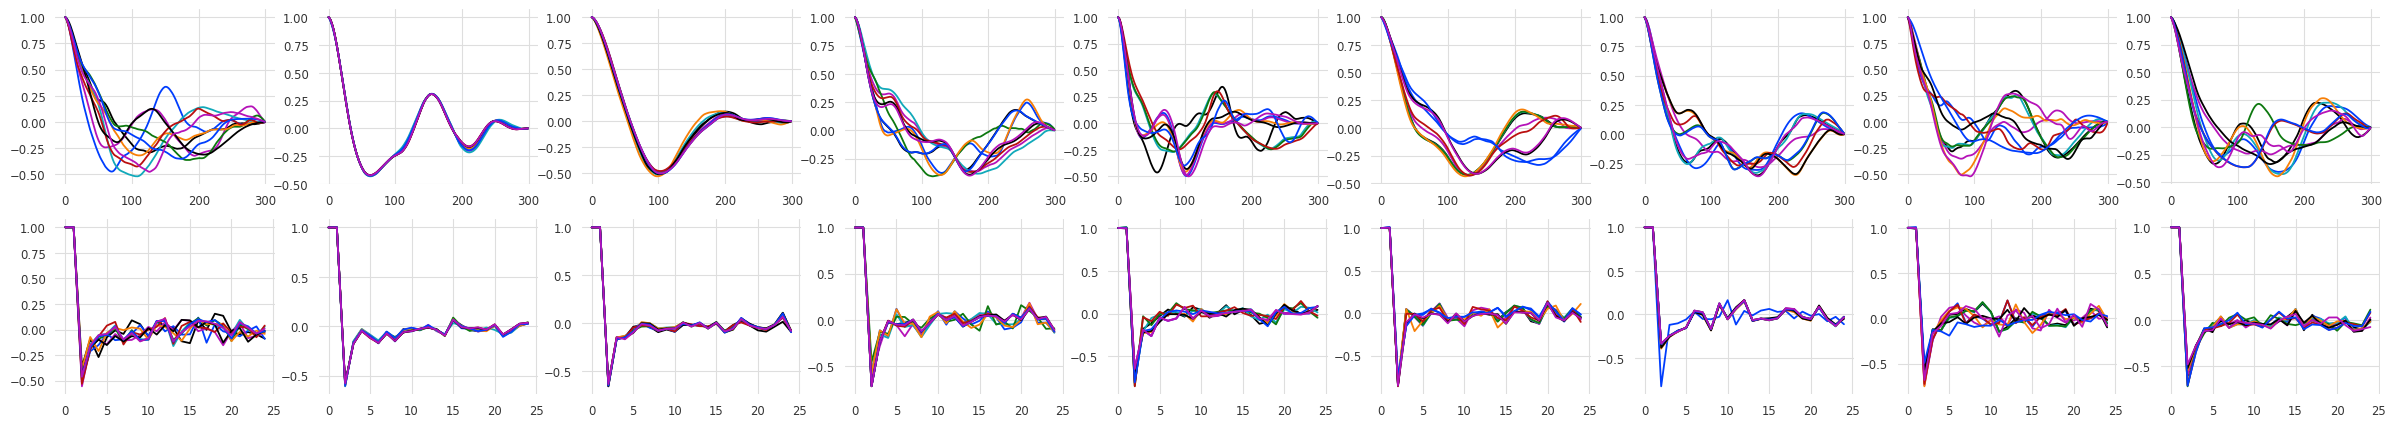

In [7]:
# plot acf of random samples from first 9 segments segments
fig, ax = plt.subplots(2, num_segments, figsize=(30, 5))
lags = 300; k = 0
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data = data['gl']
    if len(data) < lags:
        print('Segment {} is too short'.format(group))
        continue
    else:
        # select 10 random samples from index of data
        sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)
        # plot acf / pacf of each sample
        for j in sample:
            acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
            pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
            ax[0, k].plot(acf)
            ax[1, k].plot(pacf)
        k += 1
        if k >= num_segments:
            break

It is very hard to name the proper parameters for ARIMA model based on current ACF and PACF plots since within each segment, samples are behaving very differently showing different structures suitable for ARIMA model. However, we can still spot some common traits between segments. First, the autocorrelation graphs decays exponentially for almost every segment, on average, up to 20-50 lags (in some cases up to 100). Hence, the Auto Regression (AR) parameter can be set around these numbers. The partial autocorrelation plots pick around 2 for the first time and become close to zero after 5 lags at max. So, the Moving Average (MA) parameter can be set at 2. 

# Change the config according to the observations above

In [8]:
with open('./config/weinstock.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
# set interpolation params for no interpolation
config['interpolation_params']['gap_threshold'] = 45
config['interpolation_params']['min_drop_length'] = 240
# set split params for no splitting
config['split_params']['test_percent_subjects'] = 0.1
config['split_params']['length_segment'] = 240
# set scaling params for no scaling
config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 1416
	Extracted segments: 681
	Interpolated values: 140564
	Percent of values interpolated: 24.24%
Splitting data...
	Train: 357814 (68.58%)
	Val: 96960 (18.58%)
	Test: 125008 (23.96%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


# Models

## Convert data and (optional) scaling

In [9]:
# convert to series
time_col = formatter.get_column('time')
group_col = formatter.get_column('sid')
target_col = formatter.get_column('target')
static_cols = formatter.get_column('static_covs')
static_cols = static_cols + [formatter.get_column('id')] if static_cols is not None else [formatter.get_column('id')]
dynamic_cols = formatter.get_column('dynamic_covs')
future_cols = formatter.get_column('future_covs')

# build series
series, scalers = make_series({'train': formatter.train_data,
                                'val': formatter.val_data,
                                'test': formatter.test_data},
                                time_col,
                                group_col,
                                {'target': target_col,
                                'static': static_cols,
                                'dynamic': dynamic_cols,
                                'future': future_cols})

## ARIMA

In [10]:
# supress warnings
arima = models.AutoARIMA(autoarima_args={'start_p': 0,
                                         'start_q': 0,
                                         'max_p': 10,
                                         'max_q': 10,
                                         'start_P': 0,
                                         'start_Q': 0,
                                         'max_P': 10,
                                         'max_Q': 10,
                                         'max_order': None,})
forecasts = arima.historical_forecasts(series['val']['target'][:10],
                                      train_length=156,
                                      forecast_horizon=12,
                                      stride=12,
                                      retrain=True,
                                      last_points_only=False,
                                      verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

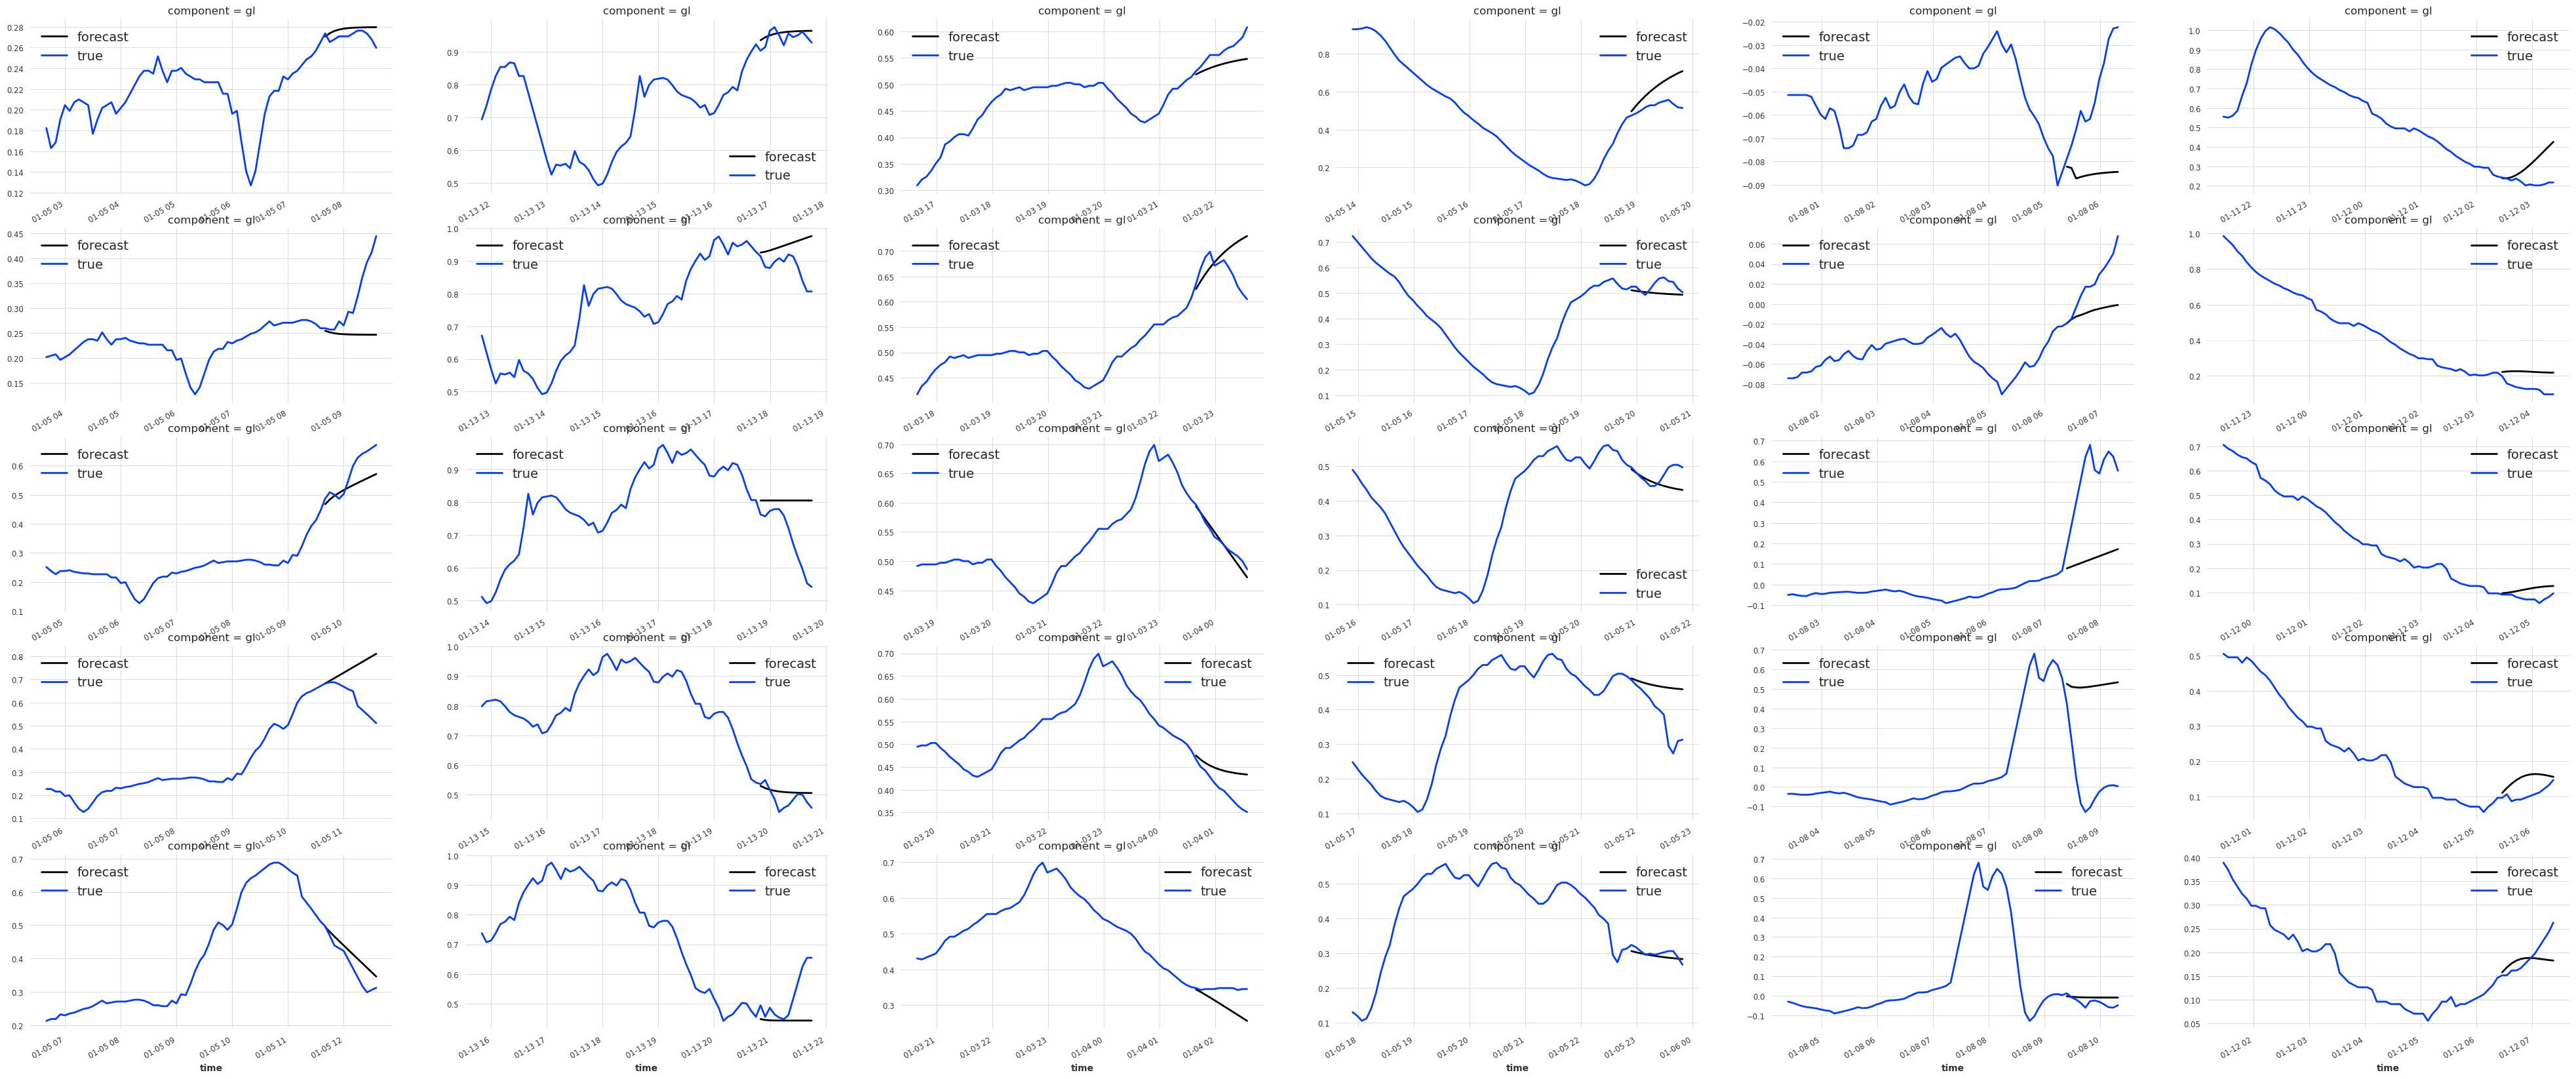

In [21]:
fig, axs = plt.subplots(5, 6, figsize=(50, 20))
for i in range(6):
    for j, f in enumerate(forecasts[i][:5]):
        f.plot(ax=axs[j, i], label='forecast')
        series['val']['target'][i].slice_n_points_after(f.time_index[0] - pd.Timedelta("5h"), 72).plot(ax=axs[j, i], label='true')
        axs[j, i].legend(fontsize=14)